In [ ]:
import pandas as pd

# indlæs data
df = pd.read_csv("heart_attack_prediction_dataset-2.csv")

# tjek data
print(df.head())
print(df.info())

  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  

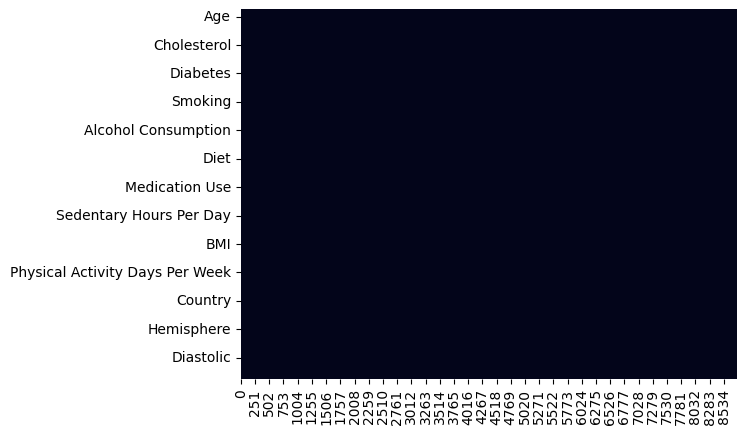

In [ ]:
# tjekke for manglende værdier i datasættet
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna().T, cbar=False)  
plt.show()


In [21]:
# fjerne patient id fra datasættet
df.drop(["Patient ID"], axis=1, inplace=True)
df.head()

KeyError: "['Patient ID'] not found in axis"

In [ ]:
# opdeler blodtryk i systolisk og diastolisk
import numpy as np

bp = (
    df['Blood Pressure']
      .astype('string')
      .str.strip()
      .str.replace(r'\s*\/\s*', '/', regex=True)  # "120 / 80" -> "120/80"
)

# split
parts = bp.str.split('/', n=1, expand=True)
df['Systolic']  = pd.to_numeric(parts[0], errors='coerce')
df['Diastolic'] = pd.to_numeric(parts[1], errors='coerce')

# (valgfrit) simple sanity-checks: drop/fix usandsynlige værdier
mask_bad = ~(
    df['Systolic'].between(70, 250) &
    df['Diastolic'].between(40, 150)
)
df = df.drop(columns=['Blood Pressure'])
# df.to_csv('data_with_split_bp.csv', index=False)

df.head()
# df.loc[mask_bad, ['Systolic','Diastolic']] = np.nan


,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,Systolic,Diastolic
0,67,Male,208,72,0,0,1,0,0,4.168189,...,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0,158,88
1,21,Male,389,98,1,1,1,1,1,1.813242,...,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0,165,93
2,21,Female,324,72,1,0,0,0,0,2.078353,...,28.176571,587,4,4,France,Europe,Northern Hemisphere,0,174,99
3,84,Male,383,73,1,1,1,0,1,9.828130,...,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0,163,100
4,66,Male,318,93,1,1,1,1,0,5.804299,...,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0,91,88


In [ ]:
#Jeg laver male til 1 og female til 0
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['Sex'].value_counts()



Sex
1    6111
0    2652
Name: count, dtype: int64

In [ ]:
# rykker Heart Attack Risk kolonnen til sidst
df['Heart Attack Risk'] = df.pop('Heart Attack Risk')


In [33]:
# Vi opdeler datasættet til predictors og target variable
# predictors er alle input værdierne og target variable er det vi gerne vil forudsige (Heart Attack Risk)

y = df['Heart Attack Risk'].astype(int)
X = df[['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Systolic', 'Diastolic']]


In [46]:
# her normaliserer jeg dataene for at få bedre resultater i min model
from sklearn.preprocessing import StandardScaler

# laver en scaler objekt
scaler = StandardScaler()

# fit og transform træningsdataene
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.62555713,  0.65876515, -0.64157889, ..., -0.51474999,
         0.87004439,  0.19378181],
       [-1.53932232,  0.65876515,  1.59689495, ..., -0.01182278,
         1.13571444,  0.53448043],
       [-1.53932232, -1.51799165,  0.79302313, ..., -1.52060442,
         1.47729021,  0.94331876],
       ...,
       [-0.3156948 ,  0.65876515, -0.12215402, ..., -1.52060442,
         0.98390298, -0.69203458],
       [-0.83338337,  0.65876515, -1.01259666, ...,  0.49110444,
        -0.6101173 , -1.23715237],
       [-1.35107193, -1.51799165,  1.18877541, ..., -1.52060442,
         0.11098711, -1.23715237]], shape=(8763, 21))

In [42]:
# Nu opdeler vi data i trænings- og test-sæt (Så vi kan træne modellen på træningssættet og teste den på data den ikke har set før)
from sklearn.model_selection import train_test_split

# funktionen neden retunere 4 forskellige værdier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)


In [43]:
# træning af logistisk regressionsmodel:
from sklearn.linear_model import LogisticRegression

# laver lr modellen
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# træner modellen på træningsdataene
lr.fit(X_train, y_train)

# forudsige target variabler på baggrund af test dataene
y_pred = lr.predict(X_test)
y_pred

array([1, 1, 1, ..., 0, 0, 0], shape=(2629,))

In [48]:
# Evaluering af modellen
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy: .2f}")

Model Accuracy:  0.50


In [47]:
# Præcision test
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.51      0.57      1691
           1       0.35      0.49      0.41       938

    accuracy                           0.50      2629
   macro avg       0.50      0.50      0.49      2629
weighted avg       0.54      0.50      0.51      2629



Chat efter mødet - 20/10/2025

In [51]:
# UDEN SCALING
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred  = lr.predict(X_test)
proba   = lr.predict_proba(X_test)[:, 1]

print("=== UDEN SCALING ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, y_pred))


=== UDEN SCALING ===
Accuracy: 0.500570559147965
ROC-AUC: 0.4994603311902093
              precision    recall  f1-score   support

           0       0.64      0.51      0.57      1691
           1       0.35      0.49      0.41       938

    accuracy                           0.50      2629
   macro avg       0.50      0.50      0.49      2629
weighted avg       0.54      0.50      0.51      2629



In [52]:
# MED SCALING
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr_scaled = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_scaled.fit(X_train_scaled, y_train)

y_pred_scaled = lr_scaled.predict(X_test_scaled)
proba_scaled  = lr_scaled.predict_proba(X_test_scaled)[:, 1]

print("=== MED SCALING ===")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("ROC-AUC:", roc_auc_score(y_test, proba_scaled))
print(classification_report(y_test, y_pred_scaled))


=== MED SCALING ===
Accuracy: 0.500570559147965
ROC-AUC: 0.49945843982755816
              precision    recall  f1-score   support

           0       0.64      0.51      0.57      1691
           1       0.35      0.49      0.41       938

    accuracy                           0.50      2629
   macro avg       0.50      0.50      0.49      2629
weighted avg       0.54      0.50      0.51      2629

